## Part 4: Plotting the data

In [1]:
import lsdviztools.lsdbasemaptools as bmt
from lsdviztools.lsdplottingtools import lsdmap_gdalio as gio
import lsdviztools.lsdmapwrappers as lsdmw

In [2]:
# %matplotlib notebook
DataDirectory = "./"
Base_file = "shillong_SRTM30_UTM"  

In [ ]:
fig = lsdmw.SimpleHillshade(DataDirectory,Base_file,cmap="gist_earth", save_fig=False)

In [ ]:
%matplotlib notebook

In [ ]:
fig

In [ ]:
ChannelFileName = "shillong_SRTM30_UTM_chi_data_map.csv"
channel_img = lsdmw.PrintChannels(DataDirectory,Base_file,ChannelFileName, 
                               cmap = "gist_earth",
                               size_format = "geomorphology", dpi = 300, 
                               plotting_column = "basin_key", save_fig = False)

In [ ]:
channel_img

In [ ]:
fig

In [ ]:
channel_img_name = lsdmw.PrintChannels(DataDirectory,Base_file,ChannelFileName, 
                               cmap = "gist_earth",
                               size_format = "geomorphology", dpi = 300, 
                               plotting_column = "basin_key", save_fig = True)

In [ ]:
channel_img_name

<img src="shillong_SRTM30_UTM_channels_coloured_by_basin.png" width=800>

# Working with the point data

LSDTopoTools outputs point data as csv files, which can be read into geopandas dataframes. You can then use these for plotting.

In [8]:
import pandas as pd
import geopandas as gpd
import numpy as np

In [3]:
DataDirectory = "./"
Base_file = "shillong_SRTM30_UTM"  
ChannelFileName = Base_file+"_chi_data_map.csv"
chi_csv_fname = DataDirectory+ChannelFileName
df = pd.read_csv(chi_csv_fname)

The csv file has latitude and longitude coordinates, so we can use these to register the geometry with a `geopandas` dataframe, and we can also set the coordinate reference system (`set_crs`). The `latitude` and `longitude` data produced by `lsdtopotools` is always in `epsg=4326`.

In [4]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf = gdf.set_crs(epsg=4326)
print(gdf.head())

    latitude  longitude     chi  elevation  flow_distance  drainage_area  \
0  25.520114  91.901374  11.611     1778.0       113110.0       905400.0   
1  25.519843  91.901377  11.580     1777.0       113080.0       912600.0   
2  25.519574  91.901678  11.535     1777.0       113040.0       942300.0   
3  25.519301  91.901382  11.491     1777.0       113000.0       950400.0   
4  25.519030  91.901384  11.461     1777.0       112970.0       952200.0   

   source_key  basin_key                   geometry  
0           0          0  POINT (91.90137 25.52011)  
1           0          0  POINT (91.90138 25.51984)  
2           0          0  POINT (91.90168 25.51957)  
3           0          0  POINT (91.90138 25.51930)  
4           0          0  POINT (91.90138 25.51903)  


So after some experimenting, it turns out that the plotting functions are not very happy if you don't keep everything in the same coordinate system. So I need to transform the geopandas dataframe to the correct UTM coordinate system. You will probably need to make sure your rasters and your dataframes are alyways in the same coordinate system.

In [5]:
gdf2 = gdf.to_crs("EPSG:32646")

Before we plot these, I want to make a scaling function that sets the marker size as a function of drainage area. But I need to scale the marker sizes. I use a scaling with the log (base 10) of the drainage area:

In [6]:
def log_value_scaler(vals, min_scale = 0.5, max_scale = 6):
    logvals = np.log10(vals)
    minval = np.min(logvals)
    maxval = np.max(logvals)
    newvals  = np.subtract(logvals,minval)
    newvals = np.divide(newvals,(maxval-minval))
    newvals = np.multiply(newvals,max_scale-min_scale)
    newvals = np.add(newvals,min_scale)
    return newvals

In [9]:
logv = log_value_scaler(gdf2.drainage_area,min_scale=0.5, max_scale = 4)
gdf2["scaled_area"] = logv
print(gdf2.head())

    latitude  longitude     chi  elevation  flow_distance  drainage_area  \
0  25.520114  91.901374  11.611     1778.0       113110.0       905400.0   
1  25.519843  91.901377  11.580     1777.0       113080.0       912600.0   
2  25.519574  91.901678  11.535     1777.0       113040.0       942300.0   
3  25.519301  91.901382  11.491     1777.0       113000.0       950400.0   
4  25.519030  91.901384  11.461     1777.0       112970.0       952200.0   

   source_key  basin_key                        geometry  scaled_area  
0           0          0  POINT (389604.973 2822997.254)     0.503067  
1           0          0  POINT (389604.967 2822967.250)     0.507128  
2           0          0  POINT (389634.969 2822937.253)     0.523549  
3           0          0  POINT (389604.974 2822907.253)     0.527937  
4           0          0  POINT (389604.967 2822877.249)     0.528907  


Okay, lets plot a single basin, with the drainage area (selected by the scaled area) thinned.

In [18]:
gdf_b1 = gdf2[(gdf2['basin_key'] == 0) & (gdf2['scaled_area'] > 1.5)]
print(gdf_b1.head())

      latitude  longitude     chi  elevation  flow_distance  drainage_area  \
102  25.518395  91.925272  9.0592     1676.0       109190.0      7509600.0   
103  25.518397  91.925571  9.0482     1675.0       109160.0      7516800.0   
104  25.518399  91.925869  9.0373     1675.0       109130.0      7523100.0   
105  25.518672  91.926165  9.0218     1675.0       109090.0      7526700.0   
106  25.518945  91.926461  9.0063     1675.0       109050.0      7559100.0   

     source_key  basin_key                        geometry  scaled_area  
102           0          0  POINT (392004.968 2822787.251)     1.587761  
103           0          0  POINT (392034.967 2822787.253)     1.588252  
104           0          0  POINT (392064.966 2822787.254)     1.588682  
105           0          0  POINT (392094.966 2822817.248)     1.588927  
106           0          0  POINT (392124.966 2822847.253)     1.591129  


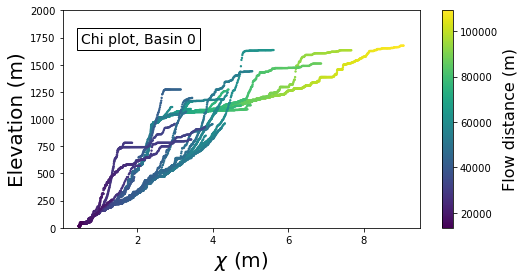

In [35]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,4))
ax = fig.add_subplot(1, 1, 1)
scat = ax.scatter(gdf_b1.chi,gdf_b1.elevation,c=gdf_b1.flow_distance,s=gdf_b1['scaled_area'])
cb = fig.colorbar(scat,)
cb.set_label(label="Flow distance (m)",size=16)

plt.text(0.5, 1800, "Chi plot, Basin 0", size=14,
         ha="left", va="top",
         bbox=dict(boxstyle="square",
                   ec=(0., 0., 0.),
                   fc=(1., 1.0, 1.0),
                   )
        )

plt.xlabel(r"$\chi$ (m)",size=20)
plt.ylabel("Elevation (m)",size=20)
ax.set_ylim(0,2000)
fig.show()